Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL11 GAN

### Lab Description

This laboratory exercise introduces **Generative Adversarial Networks (GANs)**, a framework for training two neural networks — a generator and a discriminator — in a competitive setting. Specifically, you will implement a **Deep Convolutional GAN (DCGAN)** using PyTorch.

The generator learns to produce realistic images from random noise, while the discriminator learns to distinguish between real and generated images. The two networks are trained simultaneously in an adversarial process until the generator can produce convincing fake samples.

In this lab, you will use the `MNIST` handwritten digit dataset to train your DCGAN model. By the end of training, your generator should be capable of synthesizing images that resemble real digits.

### What you can expect to learn

- Theoretical understanding: Learn the concept of adversarial training and the architecture of GANs, including generator and discriminator roles.
- Model implementation: Build and train a Deep Convolutional GAN (DCGAN) using PyTorch.
- Practical application: Generate fake MNIST digit images from noise and visualize training progress over epochs.

In [1]:
!pip install hiredis

### Import necessary libraries
This block imports necessary libraries for building and training the GAN using PyTorch.

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("GPU Name:", torch.cuda.get_device_name(0))
DATA_ROOT_IMG = os.path.expanduser("./data/images")
os.makedirs(DATA_ROOT_IMG, exist_ok=True)

### Required Dataset
We selected the MNIST digit images as the dataset for this experiment.

In [ ]:
# Parameters
batch_size = 128

# Define transformation: Resize → Tensor → Normalize to [-1, 1]
transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Load MNIST dataset
DATA_ROOT = os.path.expanduser("./data/mnist")
dataset = datasets.MNIST(root=DATA_ROOT, train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Generator (G) Network

The Generator takes random noise as input and tries to generate fake images that resemble the real data (e.g., MNIST digits). It is a deep convolutional neural network built using transposed convolutions (`ConvTranspose2d`), which progressively upsamples the input tensor to reach the desired output size.

The final layer uses `tanh()` to map output pixel values to `[-1, 1]`, matching the normalized image data range.

This setup allows the generator to learn how to generate realistic images by minimizing the adversarial loss against the discriminator.


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)

### Discriminator (D) Network

The Discriminator is a binary classifier that distinguishes between real and fake images. It receives either a real image or a generated (fake) image and outputs a probability indicating "realness".

We omit the final `sigmoid()` since we use `BCEWithLogitsLoss`, which applies sigmoid internally for numerical stability.


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 2, 0, bias=False),
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(out.size(0), -1).mean(dim=1)

### Training Setup and Initialization

This section defines the key settings for training the GAN model.


In [ ]:
batch_size = 128
latent_dim = 100
lr = 0.0002
epochs = 10

G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

### Training

The training loop runs for a fixed number of epochs. In each iteration, the discriminator is trained to distinguish between real and fake images, while the generator is trained to produce images that fool the discriminator. The generator is updated multiple times to balance learning. At the end of each epoch, sample images are generated using fixed noise and saved for later visualization.

In [7]:
save_dir = DATA_ROOT_IMG

for epoch in range(epochs):
    G.train()
    D.train()
    for i, (imgs, _) in enumerate(tqdm(dataloader)):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(z).detach()
        output_real = D(real_imgs)
        output_fake = D(fake_imgs)
        loss_D = criterion(output_real, real_labels) + criterion(output_fake, fake_labels)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator 3 times
        for _ in range(3):
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = G(z)
            output = D(fake_imgs)
            loss_G = criterion(output, real_labels)
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{epochs}] Batch {i}/{len(dataloader)} "
                f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}"
            )

    G.eval()
    with torch.no_grad():
        fake = G(fixed_noise.to(device)).detach().cpu()
        grid = vutils.make_grid(fake, padding=2, normalize=True)
        ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).byte().permute(1, 2, 0).numpy()
        save_path = os.path.join(save_dir, f"epoch_{epoch:03d}.png")
        Image.fromarray(ndarr).save(save_path)
        print(f"Saved image to {save_path}")

  0%|                           | 1/469 [00:01<11:41,  1.50s/it]

Epoch [0/1] Batch 0/469 Loss D: 1.4619, Loss G: 0.0116


 22%|█████▍                   | 101/469 [02:48<11:01,  1.80s/it]

Epoch [0/1] Batch 100/469 Loss D: 1.3696, Loss G: 0.9014


 43%|██████████▋              | 201/469 [05:45<08:19,  1.86s/it]

Epoch [0/1] Batch 200/469 Loss D: 1.4621, Loss G: 0.8000


 64%|████████████████         | 301/469 [07:51<03:03,  1.09s/it]

Epoch [0/1] Batch 300/469 Loss D: 1.3188, Loss G: 0.8041


 86%|█████████████████████▍   | 401/469 [09:35<01:14,  1.09s/it]

Epoch [0/1] Batch 400/469 Loss D: 1.3254, Loss G: 0.7005


100%|█████████████████████████| 469/469 [10:46<00:00,  1.38s/it]


Saved image to /home/aup/data/images/epoch_000.png


### Visualization

After training, the saved output images from each epoch are compiled into an animated GIF. This helps visualize how the generator improves over time in producing more realistic images.

/home/aup/data/images
GIF saved to: /home/aup/data/images/dcgan_training_progress.gif


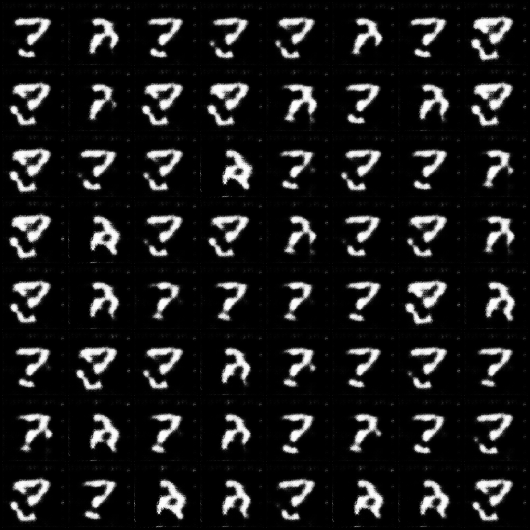

In [ ]:
import os
from pathlib import Path

import imageio.v2 as imageio
from IPython.display import Image, display

print(DATA_ROOT_IMG)
image_folder = Path(DATA_ROOT_IMG)
output_gif_path = image_folder / "dcgan_training_progress.gif"

image_folder.mkdir(parents=True, exist_ok=True)
assert os.access(image_folder, os.W_OK), f"Folder not writable: {image_folder}"


def _num_from_name(p):
    s = p.stem
    return int("".join(ch for ch in s if ch.isdigit()) or 0)


image_files = sorted([p for p in image_folder.iterdir() if p.suffix.lower() == ".png"], key=_num_from_name)

assert image_files, f"No PNGs found in {image_folder}"

images = [imageio.imread(str(p)) for p in image_files]
imageio.mimsave(str(output_gif_path), images, fps=2)

print(f"GIF saved to: {output_gif_path}")

# Display a GIF link from a local file
with open(output_gif_path, "rb") as f:
    display(Image(data=f.read(), format="gif"))